<a href="https://colab.research.google.com/github/romerocruzsa/hpc_accelerated_imaging/blob/main/data_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import lilbraries

In [ ]:
# Import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import random as rand
import seaborn as sns
sns.set()

In [ ]:
!git clone https://github.com/hardik0/AI-for-Medicine-Specialization
%cd AI-for-Medicine-Specialization/AI-for-Medical-Diagnosis/
%ls nih/

Cloning into 'AI-for-Medicine-Specialization'...
remote: Enumerating objects: 1601, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 1601 (delta 9), reused 2 (delta 0), pack-reused 1573
Receiving objects: 100% (1601/1601), 720.36 MiB | 9.21 MiB/s, done.
Resolving deltas: 100% (30/30), done.
Updating files: 100% (1497/1497), done.
/content/AI-for-Medicine-Specialization/AI-for-Medical-Diagnosis/AI-for-Medicine-Specialization/AI-for-Medical-Diagnosis
densenet.hdf5  images_small/  pretrained_model.h5  test.csv  train-small.csv  valid-small.csv


# Part 1

In [ ]:
def load_dataframe(filepath):
  df = pd.read_csv(filepath)
  print(f"Filepath: {filepath} \tRows: {df.shape[0]} \tColumns: {df.shape[1]}")
  return df

def data_statistics(data, imgs_path, info=None, show_img=None, random=True, analyze_single=None):
  id = True
  if info == True:
    print(data.info())
  if show_img == 0:
    plot_images(data, imgs_path, analyze_single=analyze_single)
  if show_img == 1:
    plot_images(data, imgs_path, colorscale='gray', analyze_single=analyze_single)

def plot_images(data, imgs_path, colorscale=None, analyze_single=None):
  imgs = data['Image'].values
  img_count = 6
  rand_imgs = [np.random.choice(images) for i in range(img_count)]

  plt.figure(figsize=(20,10))

  if analyze_single == True:
    rand_id = rand.randint(0,img_count-1)
    analyze_single_image(rand_id, rand_imgs, imgs_path, single_colorscale=colorscale)

  else:
    print(f"Displaying {img_count} images...")
    for i in range(img_count):
      plt.subplot(2, 3, i+1)
      img_block = plt.imread(os.path.join(img_dir, rand_imgs[i]))
      if colorscale == 'gray':
        plt.imshow(img_block, cmap='gray') # Add cmap = 'gray' for grayscale image
      else:
        plt.imshow(img_block) # Add cmap = 'gray' for grayscale image
    plt.tight_layout()
    plt.show()

def analyze_single_image(id, data, imgs_path, single_colorscale=None):
  sample_img = data[id]
  raw_image = plt.imread(os.path.join(img_dir, sample_img))

  plt.figure(figsize=(20,7)) # specifying the overall grid size

  if single_colorscale == 'gray':
    plot_image_hist(img, single_colorscale=single_colorscale)

  else:
    plot_image_hist(img)

def plot_image_hist(img, single_colorscale=None):
    plt.subplot(1, 2, 1)
    if single_colorscale == 'gray':
      plt.imshow(img, cmap=single_colorscale)
    else:
      plt.imshow(img)
    plt.colorbar()
    plt.title('Raw Chest X Ray Image')

    plt.subplot(1, 2, 2)
    sns.histplot(img.ravel(),
                label=f'Pixel Mean {np.mean(img):.4f} & Standard Deviation {np.std(img):.4f}', kde=False)
    sns.set_style(style='white')
    plt.legend(loc='upper center')
    plt.title('Distribution of Pixel Intensities in the Image')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('# Pixels in Image')

    plt.tight_layout()
    plt.show()

In [ ]:
train_data = load_dataframe("nih/train-small.csv")
val_data = load_dataframe("nih/valid-small.csv")
test_data = load_dataframe("nih/test.csv")

Filepath: nih/train-small.csv 	Rows: 1000 	Columns: 16
Filepath: nih/valid-small.csv 	Rows: 200 	Columns: 16
Filepath: nih/test.csv 	Rows: 420 	Columns: 16


In [ ]:
print(f"The total patient ids are {train_data['PatientId'].count()}, from those the unique ids are {train_data['PatientId'].value_counts().shape[0]} ")

# Get data columns
columns = train_data.keys()
columns = list(columns)

# Remove unnecesary elements
columns.remove('Image')
columns.remove('PatientId')

# Get the total classes
print(f"There are {len(columns)} columns of labels for these conditions: {columns}")

The total patient ids are 1000, from those the unique ids are 928 
There are 14 columns of labels for these conditions: ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [ ]:
# Print out the number of positive labels for each class
for column in columns:
    print(f"The class {column} has {train_data[column].sum()} samples")

The class Atelectasis has 106 samples
The class Cardiomegaly has 20 samples
The class Consolidation has 33 samples
The class Edema has 16 samples
The class Effusion has 128 samples
The class Emphysema has 13 samples
The class Fibrosis has 14 samples
The class Hernia has 2 samples
The class Infiltration has 175 samples
The class Mass has 45 samples
The class Nodule has 54 samples
The class Pleural_Thickening has 21 samples
The class Pneumonia has 10 samples
The class Pneumothorax has 38 samples


Displaying 6 images...


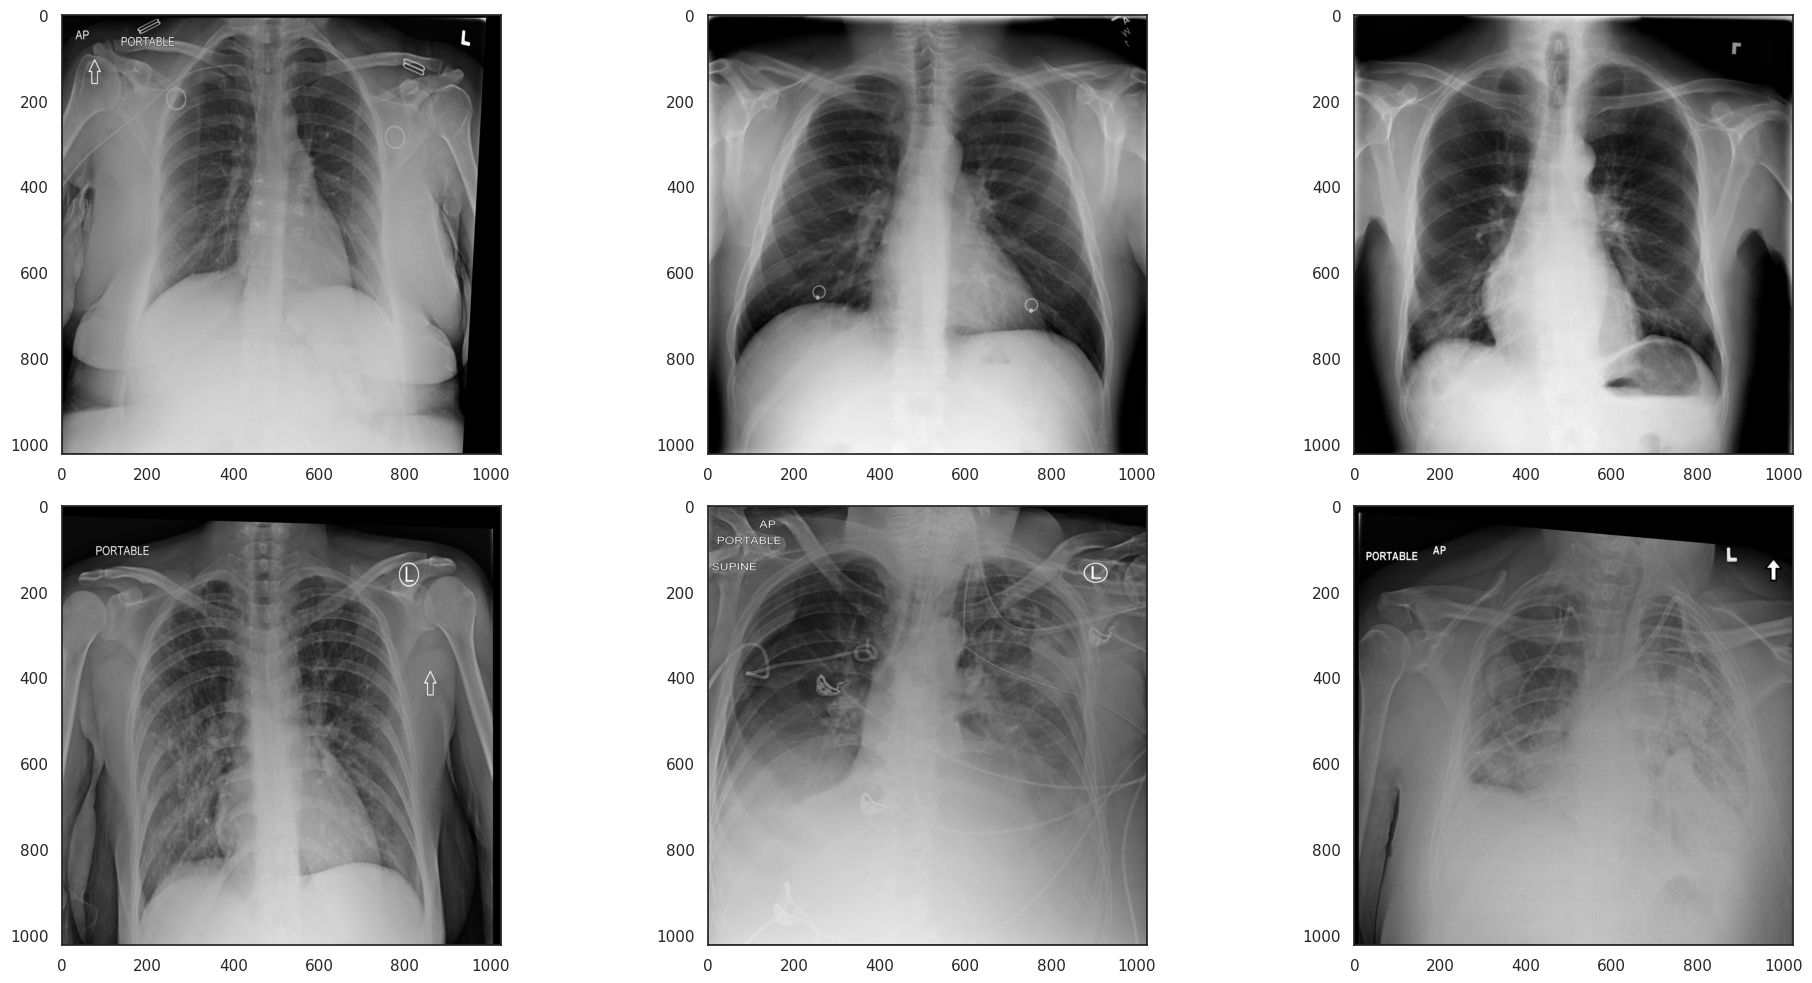

In [ ]:
data_statistics(train_data, "nih/images_small", show_img=1, analyze_single=False)

<Figure size 2000x1000 with 0 Axes>

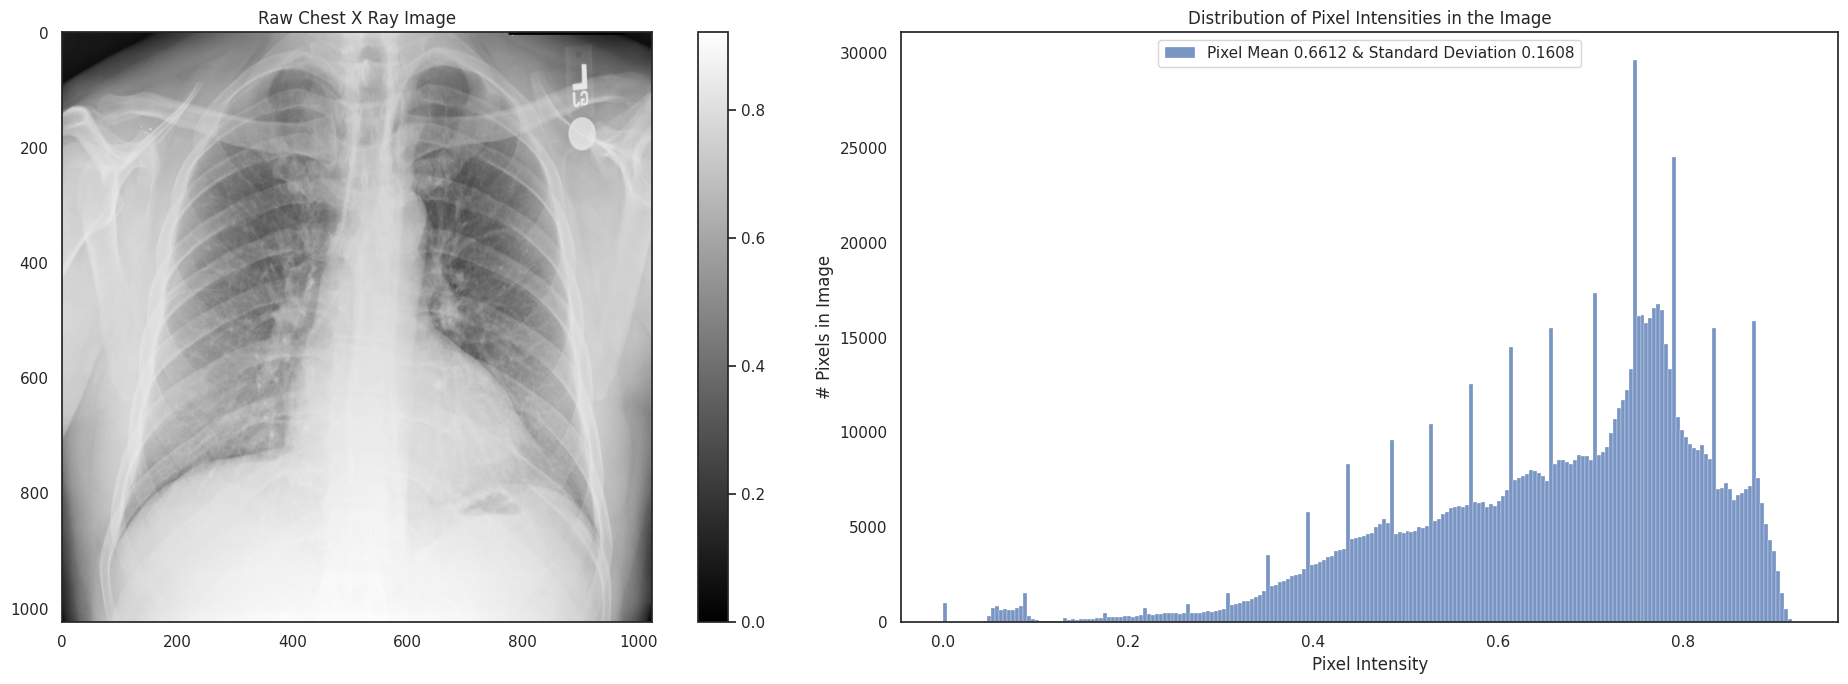

In [ ]:
data_statistics(train_data, "nih/images_small", show_img=1, analyze_single=True)

# Part 2

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.functional as T
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms

# train_set= DataLoader(DS, batch_size=64, shuffle=True)

In [ ]:
transform = transforms.Compose([torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [ ]:
%ls

densenet.hdf5  images_small/  pretrained_model.h5  test.csv  train-small.csv  valid-small.csv


In [ ]:
image_size = 64
DATA_DIR = "nih/images_small"
X_train = np.load(DATA_DIR)
print(f"Shape of training data: {X_train.shape}")
print(f"Data type: {type(X_train)}")

IsADirectoryError: ignored